In [82]:
# 자동 피팅

📤 Upload '202501_clean2.xlsx' (required)


Saving 202501_clean2.xlsx to 202501_clean2 (18).xlsx
[STEP 1] Auto-fit 14 dists on '202501_clean2 (18).xlsx', plot TOP-2 only ...
✅ Summary Excel → fit_outputs_top3/Tx-적합도_auto.xlsx
   Figures → fit_outputs_top3/[metal]_top2.png & all_metals_onepage_top2.png


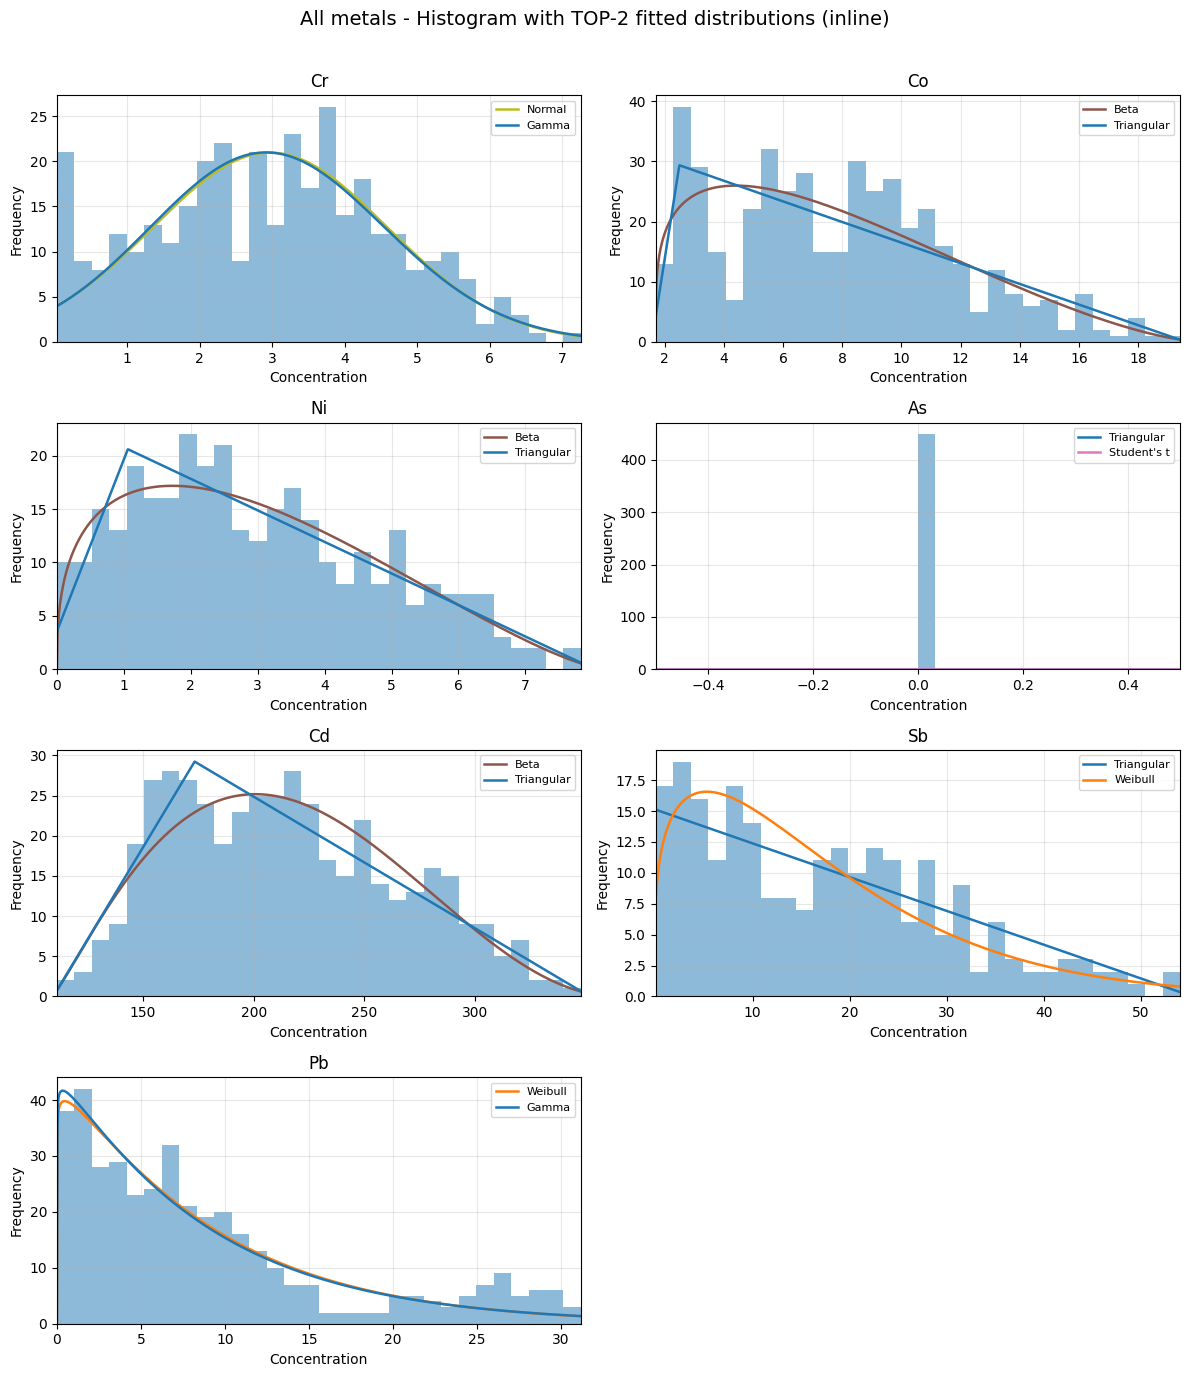

In [ ]:
import numpy as np
import pandas as pd
import math, os, re, warnings
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import (
    gamma, weibull_min, expon, lognorm, gumbel_r, beta, t, logistic, norm,
    gumbel_l, triang, pareto, uniform, chi2
)
warnings.filterwarnings("ignore")

try:
    from google.colab import files
    IN_COLAB = True
    print("Upload '202501_clean2.xlsx' (required)")
    up = files.upload()
    INPUT_FILENAME = "202501_clean2.xlsx" if "202501_clean2.xlsx" in up else next(
        (k for k in up.keys() if k.lower().endswith((".xlsx",".xls"))), None
    )
    if INPUT_FILENAME is None:
        raise FileNotFoundError("엑셀 파일(.xlsx/.xls)을 업로드하세요.")
except Exception:
    IN_COLAB = False
    INPUT_FILENAME = "202501_clean2.xlsx"  # 로컬 실행 시 파일 경로

# 1) 사용자 설정
METALS_ORDER = ["Cr", "Co", "Ni", "As", "Cd", "Sb", "Pb"]
SAVE_DIR = "fit_outputs_top3"; os.makedirs(SAVE_DIR, exist_ok=True)

# 히스토그램 bin 정책
MIN_BINS = 30
MAX_BINS = 70
TARGET_BINS = None
RNG_SEED = 42
N_BOOT = 200
rng = np.random.default_rng(RNG_SEED)

# 2) 유틸 함수
def find_metal_column(df: pd.DataFrame, metal: str):
    cols = list(df.columns)
    for c in cols:
        if str(c).strip().lower() == metal.lower():
            return c
    cand = [c for c in cols if re.search(rf"\b{re.escape(metal)}\b", str(c), flags=re.I)]
    if cand: return sorted(cand, key=lambda x: len(x))[0]
    cand = [c for c in cols if str(c).strip().lower().startswith(metal.lower())]
    if cand: return sorted(cand, key=lambda x: len(x))[0]
    return None

# BetaPERT
class BetaPERT:
    def __init__(self, lam=4.0): self.lam = lam
    @staticmethod
    def _hist_mode(x, bins=50):
        h, e = np.histogram(x, bins=bins); i = np.argmax(h)
        return 0.5*(e[i] + e[i+1])
    def fit(self, x):
        x = np.asarray(x); a, b = np.min(x), np.max(x)
        if a == b: raise ValueError("All values identical for BetaPERT.")
        bins = min(60, max(20, int(np.sqrt(len(x)))))
        m = self._hist_mode(x, bins=bins)
        alpha = 1 + self.lam*(m-a)/(b-a)
        beta_ = 1 + self.lam*(b-m)/(b-a)
        return (alpha, beta_, a, b-a)
    @staticmethod
    def _to_unit(x, loc, scale): return (x - loc)/scale
    def pdf(self, x, a, b, loc, scale):
        z = self._to_unit(x, loc, scale); return stats.beta.pdf(z, a, b) / scale
    def cdf(self, x, a, b, loc, scale):
        z = self._to_unit(x, loc, scale); return stats.beta.cdf(z, a, b)
    def rvs(self, size, alpha, beta_, loc, scale, random_state=None):
        z = stats.beta.rvs(alpha, beta_, size=size, random_state=random_state); return loc + scale*z

BetaPERTDist = BetaPERT(lam=4.0)

# 분포 레지스트리
DIST_REGISTRY = {
    "Gamma":        {"kind":"scipy", "dist": gamma},
    "Weibull":      {"kind":"scipy", "dist": weibull_min},
    "Exponential":  {"kind":"scipy", "dist": expon},
    "Lognormal":    {"kind":"scipy", "dist": lognorm},
    "Maximum Extreme Value": {"kind":"scipy", "dist": gumbel_r},
    "Beta":         {"kind":"scipy", "dist": beta},
    "Student's t":  {"kind":"scipy", "dist": t},
    "Logistic":     {"kind":"scipy", "dist": logistic},
    "Normal":       {"kind":"scipy", "dist": norm},
    "Minimum Extreme Value": {"kind":"scipy", "dist": gumbel_l},
    "Triangular":   {"kind":"scipy", "dist": triang},
    "BetaPERT":     {"kind":"custom","dist": BetaPERTDist},
    "Pareto":       {"kind":"scipy", "dist": pareto},
    "Uniform":      {"kind":"scipy", "dist": uniform},
}
POSITIVE_ONLY = {"Gamma","Weibull","Exponential","Lognormal","Beta","BetaPERT","Pareto"}

# 분포별 고정 색상
DIST_COLORS = {
    "Gamma": "tab:blue",
    "Weibull": "tab:orange",
    "Exponential": "tab:green",
    "Lognormal": "tab:red",
    "Maximum Extreme Value": "tab:purple",
    "Beta": "tab:brown",
    "Student's t": "tab:pink",
    "Logistic": "tab:gray",
    "Normal": "tab:olive",
    "Minimum Extreme Value": "tab:cyan",
    "Triangular": "tab:blue",
    "BetaPERT": "tab:orange",
    "Pareto": "tab:green",
    "Uniform": "tab:red",
}

def freedman_diaconis_bins(x, min_bins=30, max_bins=70, target_bins=None):
    x = np.asarray(x); x = x[~np.isnan(x)]
    if target_bins is not None and target_bins > 1: return int(target_bins)
    q75, q25 = np.percentile(x, [75,25]); iqr = q75 - q25; n = len(x)
    if iqr == 0: return max(min_bins, min(max_bins, int(np.sqrt(n))))
    h = 2 * iqr * (n ** (-1/3))
    if h <= 0: return max(min_bins, min(max_bins, int(np.sqrt(n))))
    bins = int(np.ceil((x.max() - x.min()) / h))
    return max(2, max(min_bins, min(max_bins, bins)))

def merge_low_expected(obs, exp, min_expected=5.0):
    obs = obs.astype(float).tolist(); exp = exp.astype(float).tolist(); i=0
    while i < len(exp):
        if exp[i] < min_expected:
            if i == 0 and len(exp) > 1:
                exp[i+1]+=exp[i]; obs[i+1]+=obs[i]; del exp[i]; del obs[i]
            elif i == len(exp)-1 and len(exp) > 1:
                exp[i-1]+=exp[i]; obs[i-1]+=obs[i]; del exp[i]; del obs[i]; i-=1
            elif len(exp) > 2:
                if exp[i-1] <= exp[i+1]:
                    exp[i-1]+=exp[i]; obs[i-1]+=obs[i]; del exp[i]; del obs[i]; i-=1
                else:
                    exp[i+1]+=exp[i]; obs[i+1]+=obs[i]; del exp[i]; del obs[i]
            else: break
        else: i+=1
    return np.array(obs), np.array(exp)

def ad_statistic(x, cdf_callable):
    x = np.sort(np.asarray(x)); n = len(x)
    F = np.clip(cdf_callable(x), 1e-12, 1-1e-12)
    i = np.arange(1, n+1); S = np.sum((2*i-1) * (np.log(F) + np.log(1 - F[::-1])))
    return float(-n - S/n)

def ad_pvalue_via_param_boot(x, dist_name, params, B=N_BOOT):
    spec = DIST_REGISTRY[dist_name]; kind, dist = spec["kind"], spec["dist"]
    def cdf_fn(xx):
        if kind == "scipy": return dist.cdf(xx, *params)
        a,b,loc,scale = params; return dist.cdf(xx, a,b,loc,scale)
    A_obs = ad_statistic(x, cdf_fn); n = len(x); cnt = 0
    for _ in range(B):
        if kind == "scipy": samp = dist.rvs(*params, size=n, random_state=rng)
        else:
            a,b,loc,scale = params
            samp = BetaPERTDist.rvs(size=n, alpha=a, beta_=b, loc=loc, scale=scale, random_state=rng)
        A_boot = ad_statistic(np.sort(samp), cdf_fn)
        if A_boot >= A_obs: cnt += 1
    return A_obs, (cnt + 1) / (B + 1)

def fit_and_gof(x, dist_name):
    x = np.asarray(x); n = len(x)
    out = {"Distribution": dist_name,
           "A-D": np.nan, "A-D p-value": np.nan,
           "K-S": np.nan, "K-S p-value": np.nan,
           "Chi-square": np.nan, "Chi-square p-value": np.nan,
           "Parameters": None}
    spec = DIST_REGISTRY[dist_name]; kind, dist = spec["kind"], spec["dist"]
    try:
        params = dist.fit(x) if kind=="scipy" else dist.fit(x)
    except Exception as e:
        out["Parameters"] = f"FitError: {e}"; return out
    out["Parameters"] = tuple(float(p) for p in params)

    # KS
    try:
        if kind=="scipy":
            ks_stat, ks_p = stats.kstest(x, dist.cdf, args=params, mode="auto")
        else:
            a,b,loc,scale = params
            xs = np.sort(x); ecdf = np.arange(1, n+1)/n
            F = BetaPERTDist.cdf(xs, a,b,loc,scale)
            ks_stat = float(np.max(np.abs(ecdf - F))); ks_p = float(stats.kstwo.sf(ks_stat, n))
        out["K-S"], out["K-S p-value"] = ks_stat, ks_p
    except Exception: pass

    # 카이제곱
    try:
        bins = freedman_diaconis_bins(x, MIN_BINS, MAX_BINS, TARGET_BINS)
        hist, edges = np.histogram(x, bins=bins)
        if kind=="scipy": cdf = lambda v: dist.cdf(v, *params)
        else:
            a,b,loc,scale = params; cdf = lambda v: BetaPERTDist.cdf(v, a,b,loc,scale)
        exp = n * (cdf(edges[1:]) - cdf(edges[:-1]))
        obs_m, exp_m = merge_low_expected(hist, exp, min_expected=5.0)
        dof = max(1, len(obs_m) - len(params) - 1)
        chi_stat = np.sum((obs_m - exp_m)**2 / np.clip(exp_m, 1e-12, None))
        chi_p = 1 - chi2.cdf(chi_stat, dof)
        out["Chi-square"], out["Chi-square p-value"] = float(chi_stat), float(chi_p)
    except Exception: pass

    # AD
    try:
        if kind=="scipy": cdf_fn = lambda v: dist.cdf(v, *params)
        else:
            a,b,loc,scale = params; cdf_fn = lambda v: BetaPERTDist.cdf(v, a,b,loc,scale)
        A, Ap = ad_pvalue_via_param_boot(x, dist_name, params, B=N_BOOT)
        out["A-D"], out["A-D p-value"] = float(A), float(Ap)
    except Exception: pass

    return out

def format_params(params):
    if params is None or isinstance(params, str): return str(params)
    try: return ", ".join([f"{p:.5g}" for p in params])
    except Exception: return str(params)

def select_top3(summary_df: pd.DataFrame):
    df = summary_df.copy()
    for col in ["A-D p-value","K-S p-value","Chi-square p-value"]:
        df[col] = df[col].fillna(-1)
    df["A-D"] = df["A-D"].fillna(np.inf)
    df = df.sort_values(
        by=["A-D p-value","K-S p-value","Chi-square p-value","A-D"],
        ascending=[False,        False,          False,             True]
    )
    return df.head(3)

# 3) 히스토그램 + TOP3 곡선
def plot_hist_top3(ax, data_full, title, top3_rows, params_map, target_bins=None):
    x = np.asarray(data_full)
    x = x[~np.isnan(x)]
    if len(x) < 5:
        ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(title); ax.set_xlabel("Concentration"); ax.set_ylabel("Frequency"); return

    # 꼬리 포함
    x_zoom = x

    # bin 수 계산(FD 규칙 or TARGET_BINS 고정)
    bins = freedman_diaconis_bins(x_zoom, MIN_BINS, MAX_BINS, target_bins)
    counts, edges, _ = ax.hist(x_zoom, bins=bins, density=False, alpha=0.5, label="Histogram")
    bin_w = (edges[1] - edges[0])
    x_plot = np.linspace(edges[0], edges[-1], 800)

    # TOP3 곡선만 그리기 + legend 정렬 고정
    handles, labels = [], []
    for _, row in top3_rows.iterrows():
        dname = row["Distribution"]
        params = params_map.get(dname, None)
        if params is None or isinstance(params, str):  # 피팅 실패
            continue
        spec = DIST_REGISTRY[dname]
        try:
            if spec["kind"] == "scipy":
                y = spec["dist"].pdf(x_plot, *params)
            else:
                a,b,loc,scale = params
                y = BetaPERTDist.pdf(x_plot, a,b,loc,scale)
            y_scaled = y * bin_w * len(x_zoom)
            color = DIST_COLORS.get(dname, None)
            line, = ax.plot(x_plot, y_scaled, lw=1.8, label=dname, color=color)
            handles.append(line); labels.append(dname)
        except Exception:
            continue

    # 스파이크 과도 시 자동 로그 y
    try:
        pos_counts = counts[counts > 0]
        if len(pos_counts) > 0 and (pos_counts.max() / max(1.0, np.median(pos_counts))) > 300:
            ax.set_yscale("log")
    except Exception:
        pass

    ax.set_xlim(edges[0], edges[-1])
    ax.set_title(title)
    ax.set_xlabel("Concentration")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    ax.legend(handles, labels, fontsize=8, loc='best')

# 4) 파이프라인
def run_step1_top3(input_path, save_dir=SAVE_DIR, target_bins=TARGET_BINS):
    df = pd.read_excel(input_path)

    # 금속 컬럼 매핑
    metal_cols = {}
    for m in METALS_ORDER:
        c = find_metal_column(df, m)
        if c is not None: metal_cols[m] = c
    if not metal_cols:
        raise ValueError("금속 컬럼을 찾을 수 없습니다. (Cr, Co, Ni, As, Cd, Sb, Pb)")

    writer = pd.ExcelWriter(os.path.join(save_dir, "Tx-적합도_auto.xlsx"), engine="openpyxl")

    top3_registry = {}     # {metal: 상위 3개 DF}
    params_registry = {}   # {metal: {분포명: 파라미터}}

    for metal in METALS_ORDER:
        col = metal_cols.get(metal)
        if col is None: continue
        x = pd.to_numeric(df[col], errors="coerce").values
        x = x[~np.isnan(x)]

        rows = []
        params_map = {}
        for dname in DIST_REGISTRY.keys():
            x_use = x[x > 0] if dname in POSITIVE_ONLY else x
            if len(x_use) < 5:
                rows.append({
                    "Distribution": dname,
                    "A-D": np.nan, "A-D p-value": np.nan,
                    "K-S": np.nan, "K-S p-value": np.nan,
                    "Chi-square": np.nan, "Chi-square p-value": np.nan,
                    "Parameters": "Insufficient data"
                })
                params_map[dname] = None
                continue
            res = fit_and_gof(x_use, dname)
            rows.append(res)
            params_map[dname] = res["Parameters"] if not isinstance(res["Parameters"], str) else None

        summary = pd.DataFrame(rows, columns=[
            "Distribution","A-D","A-D p-value","K-S","K-S p-value",
            "Chi-square","Chi-square p-value","Parameters"
        ])
        summary["Parameters"] = summary["Parameters"].apply(format_params)
        summary.to_excel(writer, sheet_name=metal, index=False)

        # Top3로 선별
        top3 = select_top3(summary)
        top3_registry[metal] = top3
        params_registry[metal] = params_map

        # 개별 플롯
        fig, ax = plt.subplots(figsize=(10, 5))
        plot_hist_top3(ax, x, f"{metal} - Histogram with TOP-3 fits",
                       top3_rows=top2, params_map=params_map, target_bins=target_bins)
        fig.tight_layout()
        fig.savefig(os.path.join(save_dir, f"{metal}_top3.png"), dpi=200)
        plt.close(fig)

    writer.close()

    # 한 페이지 요약
    n = len(METALS_ORDER); n_cols = 2; n_rows = math.ceil(n/n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5*n_rows))
    axes = np.array(axes).reshape(n_rows, n_cols)

    for idx, metal in enumerate(METALS_ORDER):
        r, c = divmod(idx, n_cols); ax = axes[r, c]
        col = metal_cols.get(metal)
        if col is None:
            ax.axis('off'); ax.set_title(f"{metal} - (missing)"); continue
        x = pd.to_numeric(df[col], errors="coerce").values
        x = x[~np.isnan(x)]
        top2 = top3_registry.get(metal, pd.DataFrame())
        params_map = params_registry.get(metal, {})
        plot_hist_top3(ax, x, f"{metal}",
                       top3_rows=top2, params_map=params_map, target_bins=target_bins)

    # 빈 칸 처리
    for k in range(idx+1, n_rows*n_cols):
        r, c = divmod(k, n_cols); axes[r, c].axis('off')

    fig.suptitle("All metals - Histogram with TOP-2 fitted distributions", fontsize=14)
    fig.tight_layout(rect=[0,0,1,0.97])
    fig.savefig(os.path.join(save_dir, "all_metals_onepage_top2.png"), dpi=200)
    plt.close(fig)

    return os.path.join(save_dir, "Tx-적합도_auto.xlsx")

# 5) 인라인 뷰어
def show_onepage_inline_top3(input_path=INPUT_FILENAME, target_bins=TARGET_BINS):
    """노트북 화면에서 한 페이지로 Top2 결과를 즉시 표시"""
    df = pd.read_excel(input_path)
    metal_cols = {m: find_metal_column(df, m) for m in METALS_ORDER}

    top3_by_metal, params_by_metal = {}, {}
    for metal in METALS_ORDER:
        col = metal_cols.get(metal)
        if col is None: continue
        x = pd.to_numeric(df[col], errors="coerce").values
        x = x[~np.isnan(x)]
        rows, params_map = [], {}
        for dname in DIST_REGISTRY.keys():
            x_use = x[x > 0] if dname in POSITIVE_ONLY else x
            if len(x_use) < 5:
                rows.append({"Distribution": dname, "A-D":np.nan, "A-D p-value":np.nan,
                             "K-S":np.nan, "K-S p-value":np.nan,
                             "Chi-square":np.nan, "Chi-square p-value":np.nan,
                             "Parameters":"Insufficient data"})
                params_map[dname] = None
                continue
            res = fit_and_gof(x_use, dname)
            rows.append(res)
            params_map[dname] = res["Parameters"] if not isinstance(res["Parameters"], str) else None
        summary = pd.DataFrame(rows)
        # Top3로 선별
        top3_by_metal[metal] = select_top3(summary)
        params_by_metal[metal] = params_map

    n = len(METALS_ORDER); n_cols = 2; n_rows = math.ceil(n/n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5*n_rows))
    axes = np.array(axes).reshape(n_rows, n_cols)
    for idx, metal in enumerate(METALS_ORDER):
        r, c = divmod(idx, n_cols); ax = axes[r, c]
        col = metal_cols.get(metal)
        if col is None: ax.axis('off'); ax.set_title(f"{metal} - (missing)"); continue
        x = pd.to_numeric(df[col], errors="coerce").values
        x = x[~np.isnan(x)]
        plot_hist_top3(ax, x, f"{metal}",
                       top3_rows=top3_by_metal.get(metal, pd.DataFrame()),
                       params_map=params_by_metal.get(metal, {}),
                       target_bins=target_bins)
    for k in range(idx+1, n_rows*n_cols):
        r, c = divmod(k, n_cols); axes[r, c].axis('off')
    fig.suptitle("All metals - Histogram with TOP-2 fitted distributions (inline)", fontsize=14)
    fig.tight_layout(rect=[0,0,1,0.97])
    plt.show()

# 실행
print(f"[STEP 1] Auto-fit 14 dists on '{INPUT_FILENAME}', plot TOP-3 only ...")
out_xlsx = run_step1_top3(INPUT_FILENAME, save_dir=SAVE_DIR, target_bins=TARGET_BINS)
print(f"Summary Excel → {out_xlsx}")
print(f"   Figures → {os.path.join(SAVE_DIR,'[metal]_top3.png')} & all_metals_onepage_top3.png")

# 한 페이지 인라인 출력
show_onepage_inline_top3(INPUT_FILENAME, target_bins=TARGET_BINS)

# ---- Bin 고정 예시(보고용으로 더 촘촘하게 보려면):
# TARGET_BINS = 100
# run_step1_top3(INPUT_FILENAME, save_dir=SAVE_DIR, target_bins=TARGET_BINS)
# show_onepage_inline_top3(INPUT_FILENAME, target_bins=TARGET_BINS)

In [ ]:
# 수동 피팅

📂 Upload '202501_clean2.xlsx' (raw data) and '[9.2] Tx-적합도.xlsx' (ranking table)


Saving [9.2] Tx-적합도.xlsx to [9.2] Tx-적합도 (6).xlsx
Saving 202501_clean2.xlsx to 202501_clean2 (23).xlsx
📌 금속별 Top3 분포 (혜님 기준 + 매핑 적용):
Cr : ["Student's t", 'Normal', 'Logistic']
Co : ['Weibull', 'Beta', "Student's t"]
Ni : ['Weibull', 'Maximum Extreme Value', 'Gamma']
As : ['Logistic', 'Maximum Extreme Value', 'Lognormal']
Cd : ['Lognormal', 'Gamma', 'Maximum Extreme Value']
Sb : ['Weibull', 'Maximum Extreme Value', 'Gamma']
Pb : ['Gamma', 'Weibull', 'Exponential']
As-Maximum Extreme Value fit error: int too large to convert to float


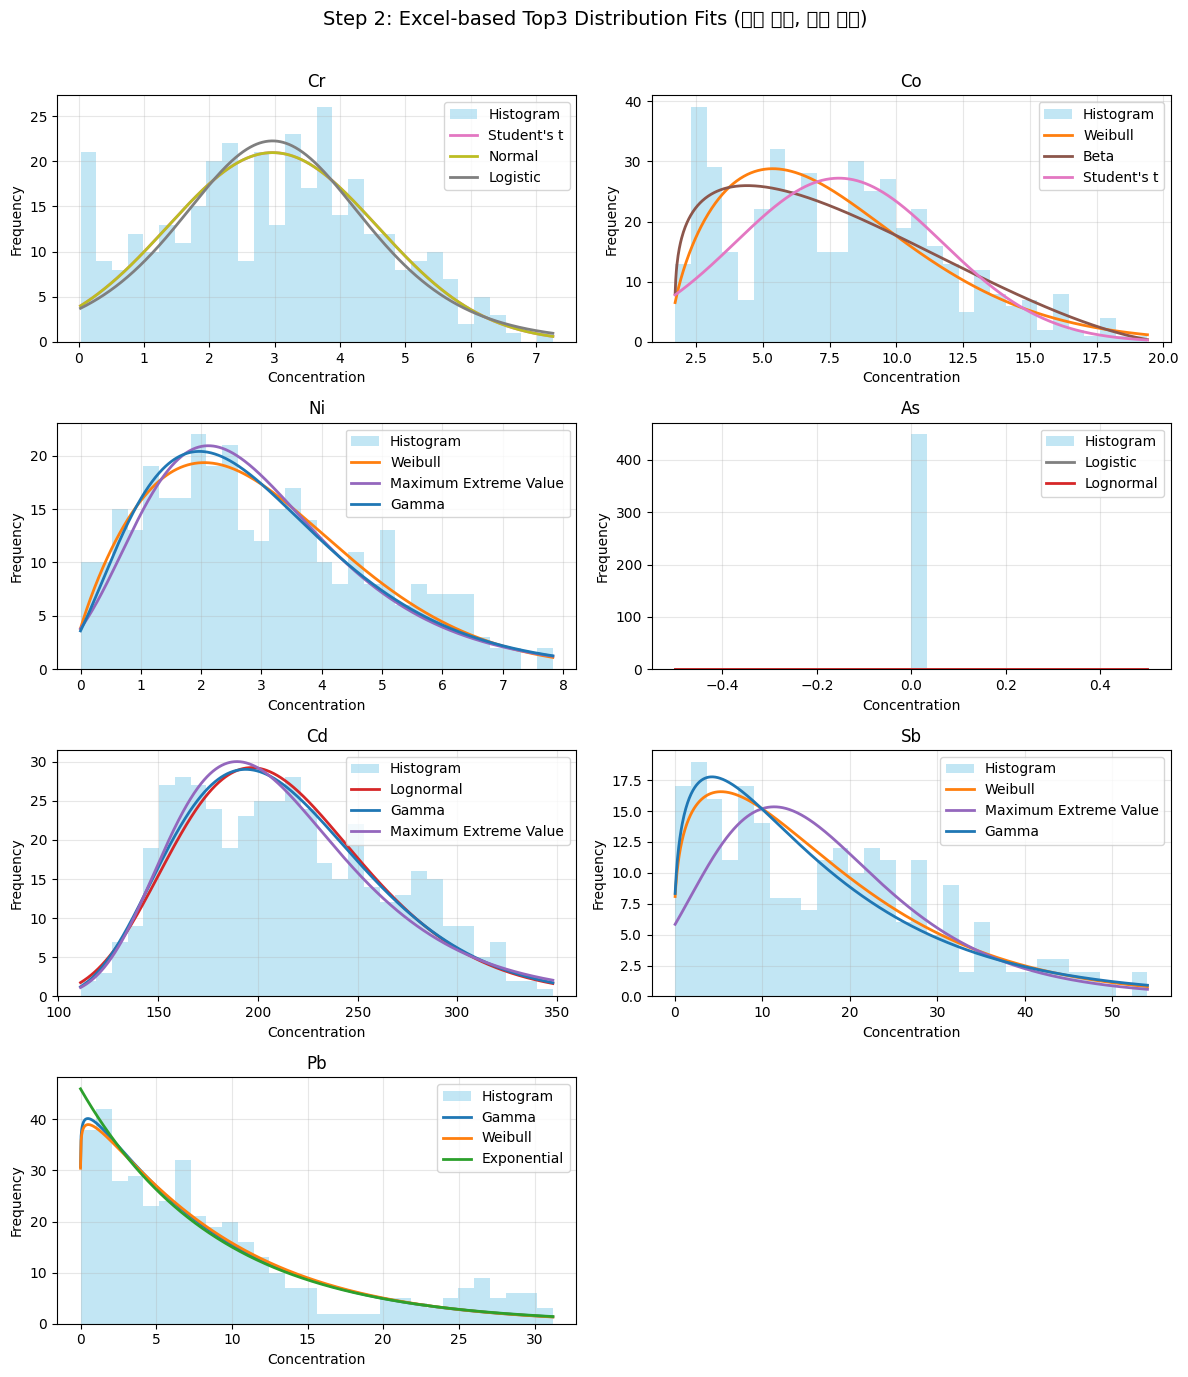

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Colab 파일 업로드
print("Upload '202501_clean2.xlsx' (raw data) and '[9.2] Tx-적합도.xlsx' (ranking table)")
uploaded = files.upload()

# 파일명 자동 매핑
INPUT_FILE = None
RANK_FILE = None
for fn in uploaded.keys():
    if "202501_clean2" in fn:
        INPUT_FILE = fn
    elif "Tx-적합도" in fn:
        RANK_FILE = fn

if INPUT_FILE is None or RANK_FILE is None:
    raise FileNotFoundError("'202501_clean2.xlsx' 와 '[9.2] Tx-적합도.xlsx' 두 파일 모두 업로드해야 합니다.")

# 영문 분포명 매핑
DIST_NAME_MAP = {
    "스튜던트의 t": "Student's t",
    "정규": "Normal",
    "로지스틱": "Logistic",
    "와이블": "Weibull",
    "최대 극값": "Maximum Extreme Value",
    "최소 극값": "Minimum Extreme Value",
    "로그 정규": "Lognormal",
    "감마": "Gamma",
    "베타": "Beta",
    "삼각형": "Triangular",
    "균일": "Uniform",
    "지수": "Exponential",
    "파레토": "Pareto",
    "BetaPERT": "BetaPERT"
}

# 분포별 색상 고정
DIST_COLORS = {
    "Gamma": "tab:blue",
    "Weibull": "tab:orange",
    "Exponential": "tab:green",
    "Lognormal": "tab:red",
    "Maximum Extreme Value": "tab:purple",
    "Beta": "tab:brown",
    "Student's t": "tab:pink",
    "Logistic": "tab:gray",
    "Normal": "tab:olive",
    "Minimum Extreme Value": "tab:cyan",
    "Triangular": "tab:blue",
    "BetaPERT": "tab:orange",
    "Pareto": "tab:green",
    "Uniform": "tab:red",
}

# 적합도표에서 금속별 Top3 추출
df_rank = pd.read_excel(RANK_FILE, sheet_name="데이터 계열", header=None)

metals = ["Cr","Co","Ni","As","Cd","Sb","Pb"]
rankings = {}

for metal in metals:
    start_idx = df_rank.index[df_rank[0] == metal].tolist()
    if not start_idx:
        continue
    start = start_idx[0] + 2
    block = []
    for i in range(start, len(df_rank)):
        if pd.isna(df_rank.iloc[i,0]) and not pd.isna(df_rank.iloc[i,1]):
            block.append(df_rank.iloc[i,1:9].values)
        else:
            if block: break

    df_block = pd.DataFrame(block, columns=["분포","A-D","A-D P-값","K-S","K-S P-값","카이제곱","카이제곱 P-값","매개 변수"])
    for col in ["A-D","A-D P-값","K-S","K-S P-값","카이제곱","카이제곱 P-값"]:
        df_block[col] = pd.to_numeric(df_block[col], errors="coerce")
    df_block["모수 수"] = df_block["매개 변수"].apply(lambda s: len(str(s).split(",")) if pd.notna(s) else 99)

    df_block_sorted = df_block.sort_values(
        by=["A-D","K-S P-값","카이제곱 P-값","모수 수"],
        ascending=[True, False, False, True]
    )

    rankings[metal] = [DIST_NAME_MAP.get(name, name) for name in df_block_sorted["분포"].head(3).tolist()]

print("금속별 Top3 분포:")
for m, lst in rankings.items():
    print(m, ":", lst)

# 로우데이터 불러오기
df = pd.read_excel(INPUT_FILE)

# Histogram bin 계산 함수
def freedman_diaconis_bins(x, min_bins=30, max_bins=70, target_bins=None):
    x = np.asarray(x); x = x[~np.isnan(x)]
    if target_bins is not None and target_bins > 1:
        return int(target_bins)
    q75, q25 = np.percentile(x, [75,25]); iqr = q75 - q25; n = len(x)
    if iqr == 0:
        return max(min_bins, min(max_bins, int(np.sqrt(n))))
    h = 2 * iqr * (n ** (-1/3))
    if h <= 0:
        return max(min_bins, min(max_bins, int(np.sqrt(n))))
    bins = int(np.ceil((x.max() - x.min()) / h))
    return max(2, max(min_bins, min(max_bins, bins)))

# 수동 피팅 함수
def manual_fit_plot(metal, dist_list, ax):
    col = find_metal_column(df, metal)
    if col is None:
        ax.set_title(f"{metal} (not found)")
        return
    x = pd.to_numeric(df[col], errors="coerce").dropna().values
    if len(x) < 5:
        ax.set_title(f"{metal} (insufficient data)")
        return

    bins = freedman_diaconis_bins(x, 30, 70)
    counts, edges, _ = ax.hist(x, bins=bins, alpha=0.5, color="skyblue", label="Histogram")
    bin_w = edges[1]-edges[0]
    x_plot = np.linspace(edges[0], edges[-1], 800)

    for dname in dist_list:
        spec = DIST_REGISTRY.get(dname)
        if spec is None:
            print(f"{metal}: 분포 {dname} registry에 없음")
            continue
        try:
            params = spec["dist"].fit(x)
            y = spec["dist"].pdf(x_plot, *params)
            plt_y = y * bin_w * len(x)
            color = DIST_COLORS.get(dname, None)
            ax.plot(x_plot, plt_y, lw=2, label=dname, color=color)
        except Exception as e:
            print(f"{metal}-{dname} fit error:", e)

    ax.set_title(metal)
    ax.set_xlabel("Concentration")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(alpha=0.3)

# 한 페이지 시각화
n = len(rankings)
n_cols = 2
n_rows = int(np.ceil(n/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5*n_rows))
axes = axes.flatten()

for idx, (metal, dlist) in enumerate(rankings.items()):
    manual_fit_plot(metal, dlist, axes[idx])

for k in range(idx+1, len(axes)):
    axes[k].axis("off")

fig.suptitle("Step 2: Excel-based Top3 Distribution Fits (혜님 기준, 색상 고정)", fontsize=14)
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()